# MMED Week 0 Project: MMED COVID-19

# The Effect of Delaying Intervention

Group 1<br>
Project: <br><br>

**Students:**<br>
 - Annette Dariose Diffo Mboudjiho
 - Dishanand Jayeprokash
 - Oumarou MOUSSA BOLA

## Data Preparation

In [1]:
# Install and load necessary packages
install.packages("remotes")
remotes::install_github("grantbrown/ABSEIR")
install.packages(c("deSolve", "ggplot2", "minpack.lm", "coda"))


Installing package into ‘/var/autofs/misc/home/jay/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

Skipping install of 'ABSEIR' from a github remote, the SHA1 (e04364a2) has not changed since last install.
  Use `force = TRUE` to force installation

Installing packages into ‘/var/autofs/misc/home/jay/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

Warning message in install.packages(c("deSolve", "ggplot2", "minpack.lm", "coda")):
“installation of package ‘deSolve’ had non-zero exit status”
Warning message in install.packages(c("deSolve", "ggplot2", "minpack.lm", "coda")):
“installation of package ‘minpack.lm’ had non-zero exit status”


In [2]:
library(ABSEIR)
library(deSolve)
library(ggplot2)
library(minpack.lm)
library(coda)
library(dplyr)

Loading required package: Rcpp

Loading required package: parallel

Loading required package: compiler


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Load the data
data(Kikwit1995)
head(Kikwit1995)

,Date,Count
,<date>,<int>
1,1995-03-06,1
2,1995-03-07,1
3,1995-03-08,1
4,1995-03-09,0
5,1995-03-10,0
6,1995-03-11,0


In [4]:
dim(Kikwit1995)

[1] 197   2

In [5]:
# Preprocess the data - Convert Date column to Date type
Kikwit1995$Date <- as.Date(Kikwit1995$Date)
# Extract the count of cases
cases <- Kikwit1995$Count
dates <- Kikwit1995$Date
times <- 1:length(cases) # Time in days

## Visualization

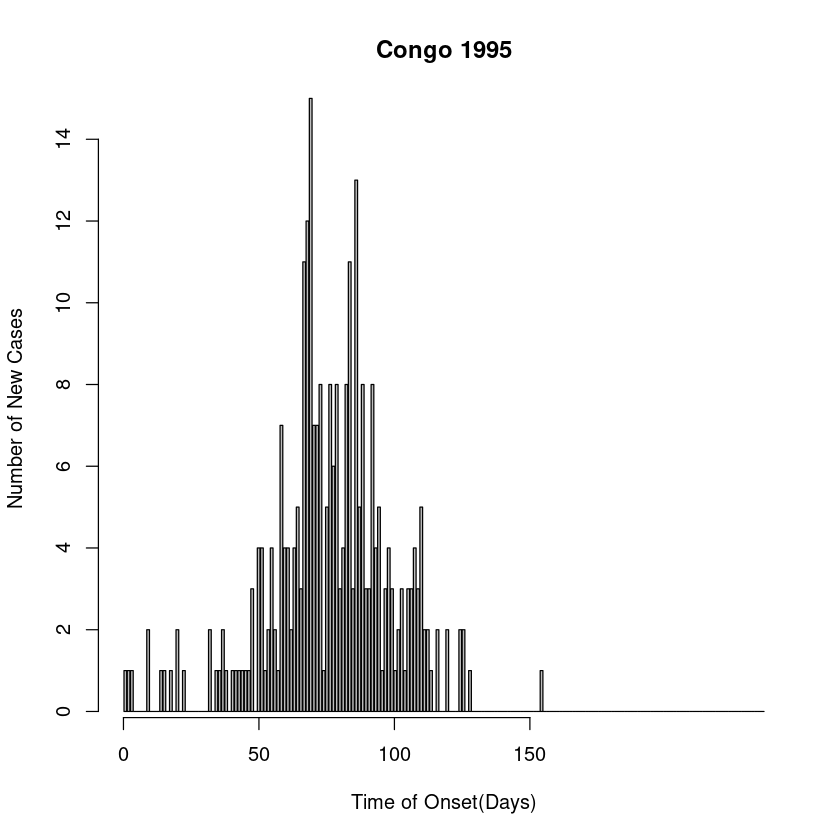

In [6]:
# Plot the real data
barplot(Kikwit1995$Count, xlab = "Time of Onset(Days)", ylab = "Number of New Cases",
        main = "Congo 1995")
axis(side = 1, at = seq(0, nrow(Kikwit1995), 50))

In [7]:
# Gaussian fitting to the real data using nlsLM
fit_gaussian <- function(data) {
  nlsLM(Count ~ a * exp(-((time - b)^2) / (2 * c^2)),
        data = data,
        start = list(a = max(data$Count), b = which.max(data$Count), c = sd(data$time)),
        control = nls.lm.control(maxiter = 100))
}

In [8]:
# Fit the Gaussian model
gaussian_fit <- fit_gaussian(data.frame(time = times, Count = cases))
fitted_values <- predict(gaussian_fit)
Kikwit1995$fitted <- fitted_values

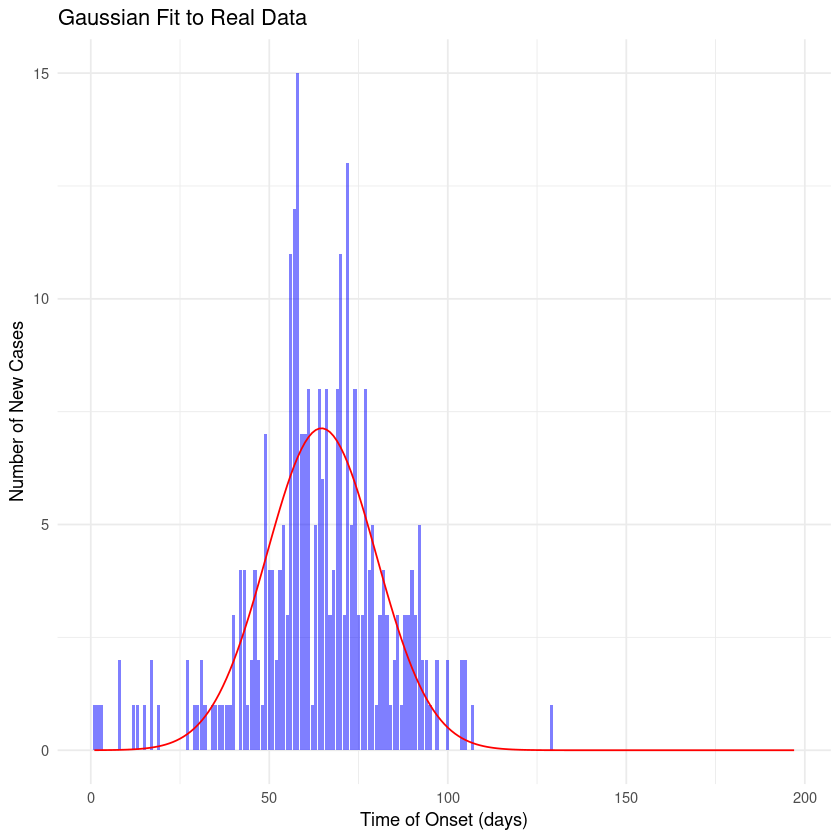

In [9]:
# Plot the real data and Gaussian fit
ggplot() +
  geom_bar(data = Kikwit1995, aes(x = times, y = Count), stat = "identity", fill = "blue", alpha = 0.5) +
  geom_line(data = Kikwit1995, aes(x = times, y = fitted), color = "red") +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal()

## Cummulative Cases of the Epidemic in Congo

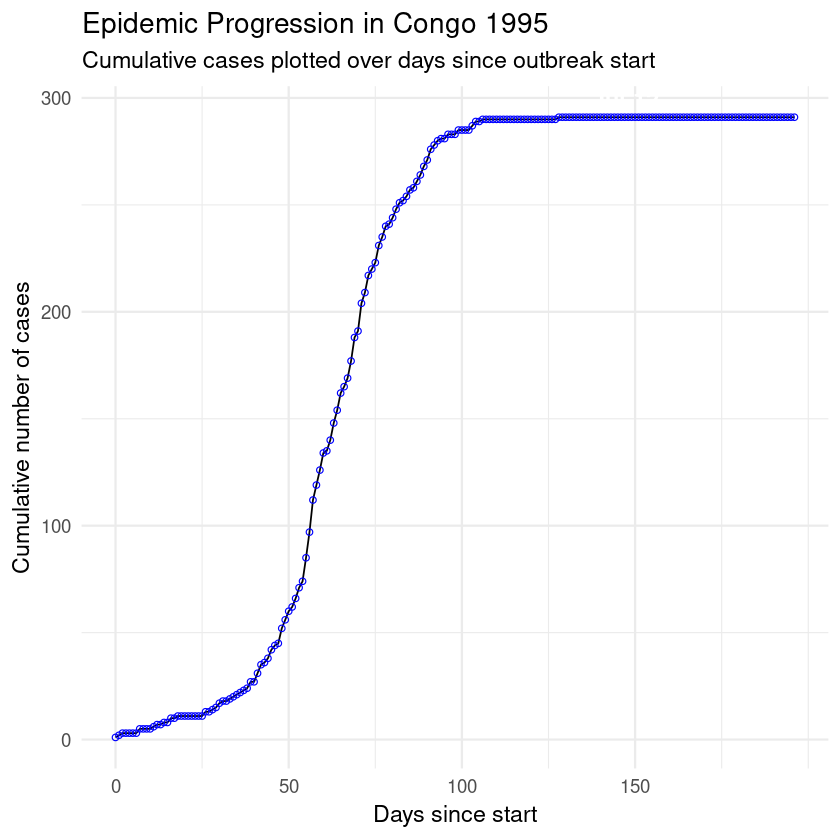

In [10]:
# Convert 'Date' to the proper format and ensure it's sorted
Kikwit1995$Date <- as.Date(Kikwit1995$Date, format = "%Y-%m-%d")
Kikwit1995 <- arrange(Kikwit1995, Date)

# Calculate the cumulative cases
Kikwit1995 <- mutate(Kikwit1995, CumulativeCases = cumsum(Count))

# Calculate days since the start of the dataset
Kikwit1995 <- mutate(Kikwit1995, DaysSinceStart = as.numeric(Date - min(Date)))

# Find the values for annotations (assuming 'Date' column exists)
mar_13_date <- as.numeric(as.Date("1995-03-13") - min(Kikwit1995$Date))
mar_13_cases <- Kikwit1995$CumulativeCases[which(Kikwit1995$DaysSinceStart == mar_13_date)]
jul_12_date <- as.numeric(as.Date("1995-07-12") - min(Kikwit1995$Date))
jul_12_cases <- Kikwit1995$CumulativeCases[which(Kikwit1995$DaysSinceStart == jul_12_date)]

ggplot(Kikwit1995, aes(x = DaysSinceStart, y = CumulativeCases)) +
   geom_line() +  # Add the line for cumulative cases
  geom_point(color="blue",shape = 1) +  # Add points for each day
  scale_x_continuous(breaks = c(0, 50, 100, 150), labels = c("0", "50", "100", "150")) +
  annotate("text", x = mar_13_date, y = mar_13_cases, label = "Mar 13", color = "white", hjust = 1.5, vjust = -0.5, fontface = "bold", size = 5) +
  annotate("text", x = jul_12_date, y = jul_12_cases, label = "Jul 12", color = "white", hjust = -0.5, vjust = -0.5, fontface = "bold", size = 5) +
  labs(title = "Epidemic Progression in Congo 1995", subtitle = "Cumulative cases plotted over days since outbreak start", x = "Days since start", y = "Cumulative number of cases") +
  theme_minimal(base_size = 14) +
  theme(plot.background = element_rect(fill = "white", colour = "white"), 
        panel.background = element_rect(fill = "white", colour = "white"))  # Set background to white



## $\beta$ as a Function of t

In [11]:
# Define the function to calculate beta(t)
beta_t <- function(t, tau, beta_0, beta_1, q) {
  if (t < tau) {
    return(beta_0)
  } else {
    return(beta_1 + (beta_0 - beta_1) * exp(-q * (t - tau)))
  }
}


## SEIR Model Implementation

In [1]:
# SEIR model differential equations
seir <- function(t, y, params) {
  S <- y[1]
  E <- y[2]
  I <- y[3]
  R <- y[4]
  C <- y[5] # Cumulative cases

  beta <- beta_t(t, params["tau"], params["beta_0"], params["beta_1"], params["q"])
  N <- params["N"]
  gamma <- params["gamma"]
  k <- params["k"]

#   dSdt < - -(beta * S * I) / N
#   dEdt <- ((beta * S * I) / N) - (k * E)
#   dIdt <- (k * E) - (gamma * I)
#   dRdt <- gamma * I
#   dCdt <- k * E
dSdt <- b*N -(beta*S*I)/N -mu*S+nu*R 
dEdt <- (beta*S*I)/N -sigma*E -mu*E
dIdt <- sigma*E-(gamma+mu+alpha1+alpha2)*I
dRdt<- gamma*I+eps1*B_n+eps2*B_icu-(nu+mu)*R
dB_ndt<-alpha1*I+lambda1*B_icu-(eps1+lambda2+mu)*B_n
dB_icudt<-alpha2*I +lambda2*B_n-(eps2+lambda1+mu)*B_icu
  return(list(c(dSdt, dEdt, dIdt, dRdt,dB_ndt,dB_icudt)))
}

## Initial Conditions

In [19]:
# Parameters and initial conditions
params <- c(
  beta_0 = 0.33,
  beta_1 = 0.09,
  k = 1/5.3,
  gamma = 1/5.61,
  tau = 56,
  q = 25,
  N = 100
)

initial_conditions <- c(S = 70, E = 29, I = 1, R = 0, C = 0)
times <- seq(1, 197, by = 1)


## Simulate SEIR Model

In [20]:
# Solve the SEIR model
seir_output <- ode(y = initial_conditions, times = times, func = seir, parms = params)


In [21]:
# Convert the output to a data frame
seir_df <- as.data.frame(seir_output)

In [22]:
head(seir_df)

,time,S,E,I,R,C
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,70.00000,29.00000,1.000000,0.0000000,0.000000
2,2,69.22949,24.73015,5.442496,0.5978666,5.040362
3,3,67.62794,21.94690,8.563002,1.8621509,9.425153
4,4,65.48980,20.12771,10.784972,3.5975231,13.382495
5,5,63.02414,18.91731,12.388082,5.6704766,17.058558
6,6,60.37707,18.07862,13.556092,7.9882211,20.544313


In [23]:
dim(seir_df)

[1] 197   6

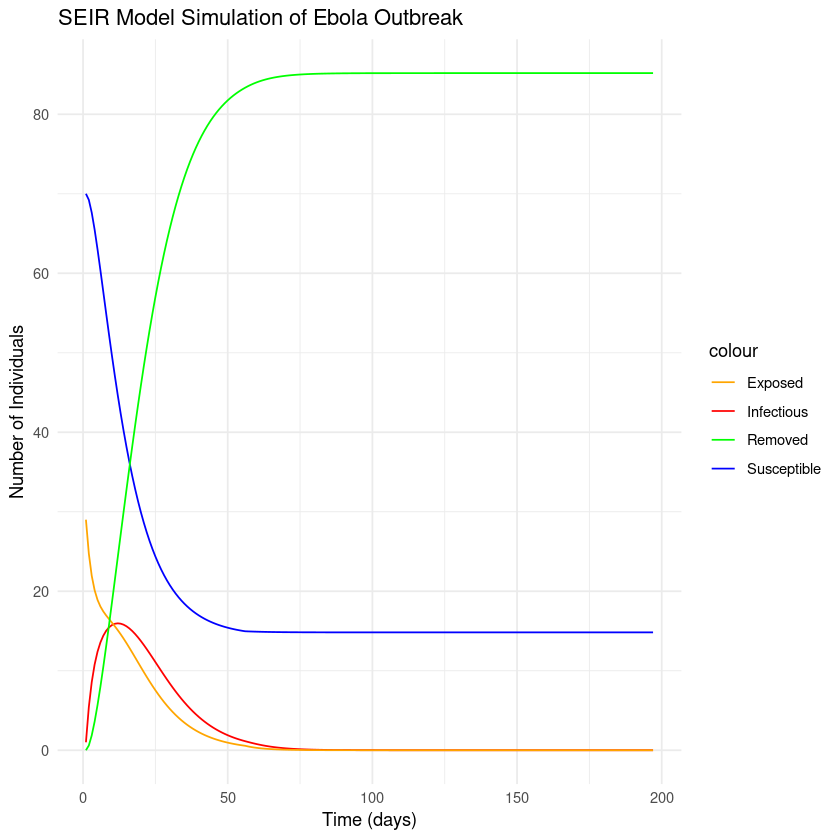

In [24]:
# Plot the simulation results
ggplot(seir_df, aes(x = time)) +
  geom_line(aes(y = I, color = "Infectious")) +
  geom_line(aes(y = E, color = "Exposed")) +
  geom_line(aes(y = S, color = "Susceptible")) +
  geom_line(aes(y = R, color = "Removed")) +
  labs(title = "SEIR Model Simulation of Ebola Outbreak",
       x = "Time (days)", y = "Number of Individuals") +
  scale_color_manual(values = c("Infectious" = "red", "Exposed" = "orange", "Susceptible" = "blue", "Removed" = "green")) +
  theme_minimal()

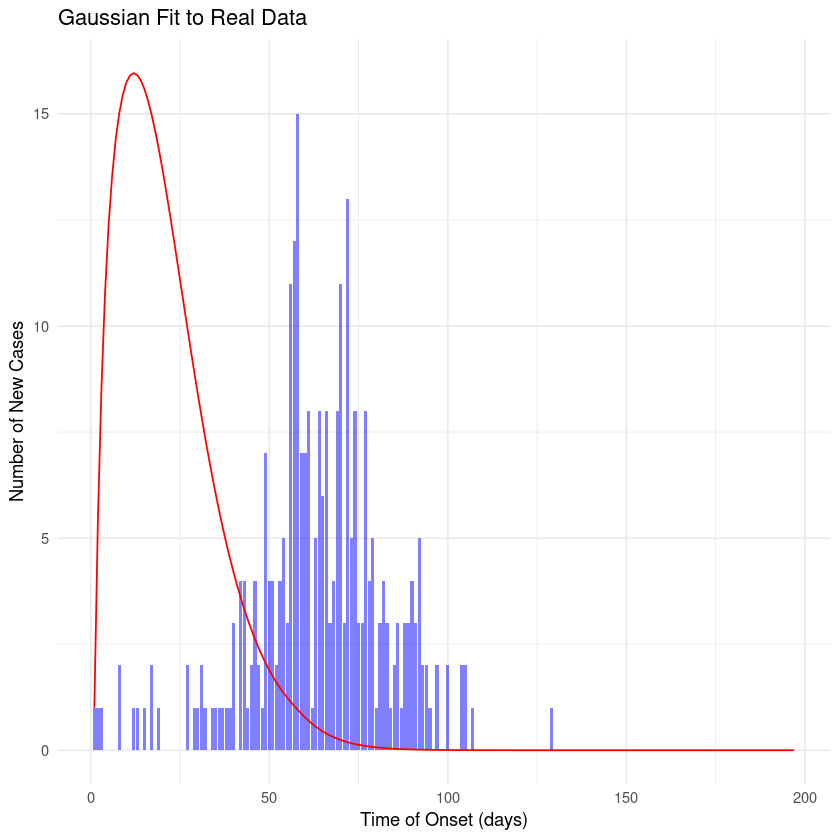

In [25]:
# Plot the real data and Gaussian fit
ggplot() +
  geom_bar(data = Kikwit1995, aes(x = times, y = Count), stat = "identity", fill = "blue", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = I), color = "red") +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal()

## Markov Chain Model To Plot S, E, I, R  Version 1

In [26]:
# Markov Chain SEIR model
simulate_markov_chain <- function(params, initial_conditions, times) {
  S <- initial_conditions["S"]
  E <- initial_conditions["E"]
  I <- initial_conditions["I"]
  R <- initial_conditions["R"]
  C <- initial_conditions["C"]
  
  N <- params["N"]
  beta_0 <- params["beta_0"]
  beta_1 <- params["beta_1"]
  k <- params["k"]
  gamma <- params["gamma"]
  tau <- params["tau"]
  q <- params["q"]

  results <- data.frame(time = times, S = numeric(length(times)), E = numeric(length(times)), I = numeric(length(times)), R = numeric(length(times)), C = numeric(length(times)))

  for (t in times) {
    beta <- beta_t(t, tau, beta_0, beta_1, q)
    
    # Calculate probabilities for the events
    p_SE <- 1 - exp(-(beta * I) / N)
    p_EI <- 1 - exp(-k)
    p_IR <- 1 - exp(-gamma)

    # Simulate the transitions
    new_exposed <- rbinom(1, S, p_SE)
    new_infectious <- rbinom(1, E, p_EI)
    new_removed <- rbinom(1, I, p_IR)

    # Update the compartments
    S <- S - new_exposed
    E <- E + new_exposed - new_infectious
    I <- I + new_infectious - new_removed
    R <- R + new_removed
    C <- C + new_exposed

    # Store the results
    results[results$time == t, ] <- c(t, S, E, I, R, C)
  }

  return(results)
}



In [27]:
# Simulate the Markov Chain model
markov_results <- simulate_markov_chain(params, initial_conditions, times)


In [28]:
head(markov_results)

,time,S,E,I,R,C
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,70,23,7,0,0
2,2,68,24,7,1,2
3,3,67,20,12,1,3
4,4,63,22,13,2,7
5,5,62,19,16,3,8
6,6,57,22,17,4,13


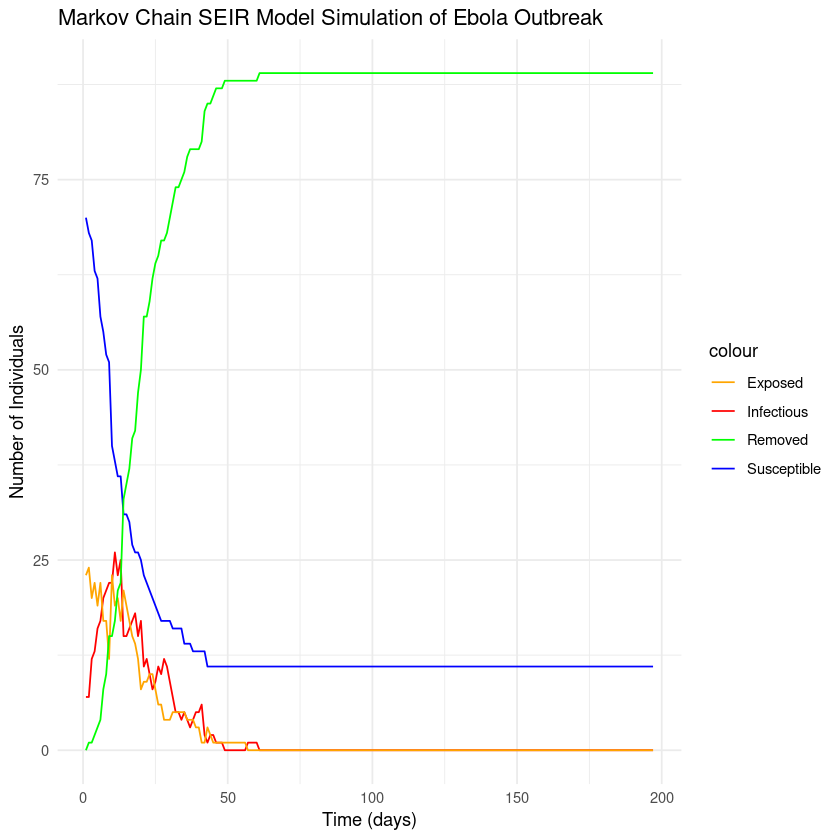

In [29]:
# Plot the Markov Chain simulation results
ggplot(markov_results, aes(x = time)) +
  geom_line(aes(y = I, color = "Infectious")) +
  geom_line(aes(y = E, color = "Exposed")) +
  geom_line(aes(y = S, color = "Susceptible")) +
  geom_line(aes(y = R, color = "Removed")) +
  labs(title = "Markov Chain SEIR Model Simulation of Ebola Outbreak",
       x = "Time (days)", y = "Number of Individuals") +
  scale_color_manual(values = c("Infectious" = "red", "Exposed" = "orange", "Susceptible" = "blue", "Removed" = "green")) +
  theme_minimal()

## Calculating $R_{0}$

In [ ]:
# # Define the function to calculate R0 over time
# R0_over_time <- function(t, R0_max, beta, period) {
#   R0_max * (1 + beta * exp(-1 * pi * t / period) + cos(1.5 * pi * t / period))
# }

In [ ]:
# # Define parameters
# R0_max <- 0.9
# beta <- 0.1
# period <- 365

In [ ]:
# # Calculate R0 values
# R0_values <- R0_over_time(times, R0_max, beta, period)

In [ ]:
# # Plot R0 over time
# ggplot(data.frame(time = times, R0 = R0_values), aes(x = time, y = R0)) +
#   geom_line(color = "blue") +
#   labs(title = "Reproductive Number (R0) Over Time",
#        x = "Time (days)", y = "Reproductive Number (R0)") +
#   theme_minimal()

## Markov Chain Model Version 2

In [30]:
# Calculate beta(t) dynamically based on time
beta_tt <- function(t, params) {
  if (t < params["tau"]) {
    return(params["beta_0"])
  } else {
    return(params["beta_1"] + (params["beta_0"] - params["beta_1"]) * exp(-params["q"] * (t - params["tau"])))
  }
}


In [31]:
# Stochastic SEIR model using Gillespie Algorithm
seir_gillespie <- function(params, initial_conditions, times) {
  t <- 0
  results <- data.frame(time = t, S = initial_conditions["S"], E = initial_conditions["E"], I = initial_conditions["I"], R = initial_conditions["R"], C = initial_conditions["C"])
  
  while(t < max(times)) {
    S <- results$S[nrow(results)]
    E <- results$E[nrow(results)]
    I <- results$I[nrow(results)]
    R <- results$R[nrow(results)]
    C <- results$C[nrow(results)]
    
    N <- params["N"]
    gamma <- params["gamma"]
    k <- params["k"]
    beta <- beta_tt(t, params)
    
    # Rates of transitions
    rate_infection <- beta * S * I / N
    rate_exposed_to_infectious <- k * E
    rate_infectious_to_removed <- gamma * I
    
    rates <- c(rate_infection, rate_exposed_to_infectious, rate_infectious_to_removed)
    total_rate <- sum(rates)
    
    if(total_rate == 0) break
    
    # Time to next event
    dt <- rexp(1, total_rate)
    t <- t + dt
    
    # Determine which event occurs
    event <- sample(1:3, 1, prob = rates)
    
    if(event == 1 && S > 0) {
      S <- S - 1
      E <- E + 1
    } else if(event == 2 && E > 0) {
      E <- E - 1
      I <- I + 1
      C <- C + 1
    } else if(event == 3 && I > 0) {
      I <- I - 1
      R <- R + 1
    }
    
    results <- rbind(results, data.frame(time = t, S = S, E = E, I = I, R = R, C = C))
  }
  
  return(results)
}


In [32]:
# Number of simulations
num_simulations <- 100
all_simulations <- list()

for(i in 1:num_simulations) {
  sim_result <- seir_gillespie(params, initial_conditions, times)
  all_simulations[[i]] <- sim_result
}


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  67.00   78.00   83.00   82.25   87.25   92.00 

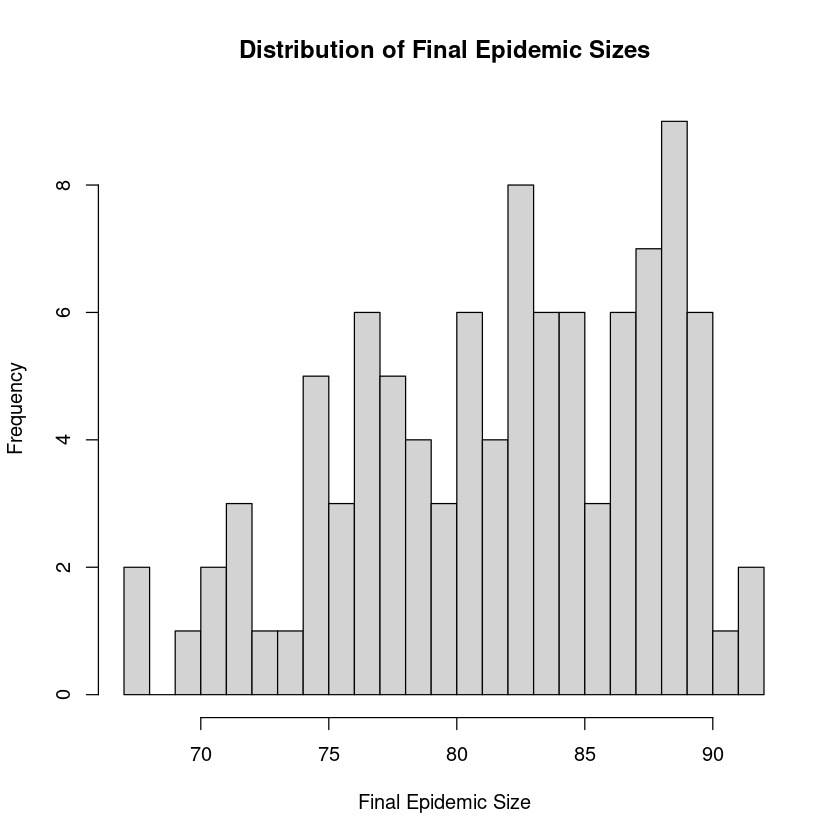

In [33]:
# Function to extract the final epidemic size from each simulation
final_epidemic_size <- function(simulation) {
  return(max(simulation$C))
}

# Calculate final epidemic sizes for all simulations
final_sizes <- sapply(all_simulations, final_epidemic_size)

# Plot the distribution of final epidemic sizes
hist(final_sizes, breaks = 30, main = "Distribution of Final Epidemic Sizes", xlab = "Final Epidemic Size", ylab = "Frequency")

# Calculate summary statistics
summary(final_sizes)


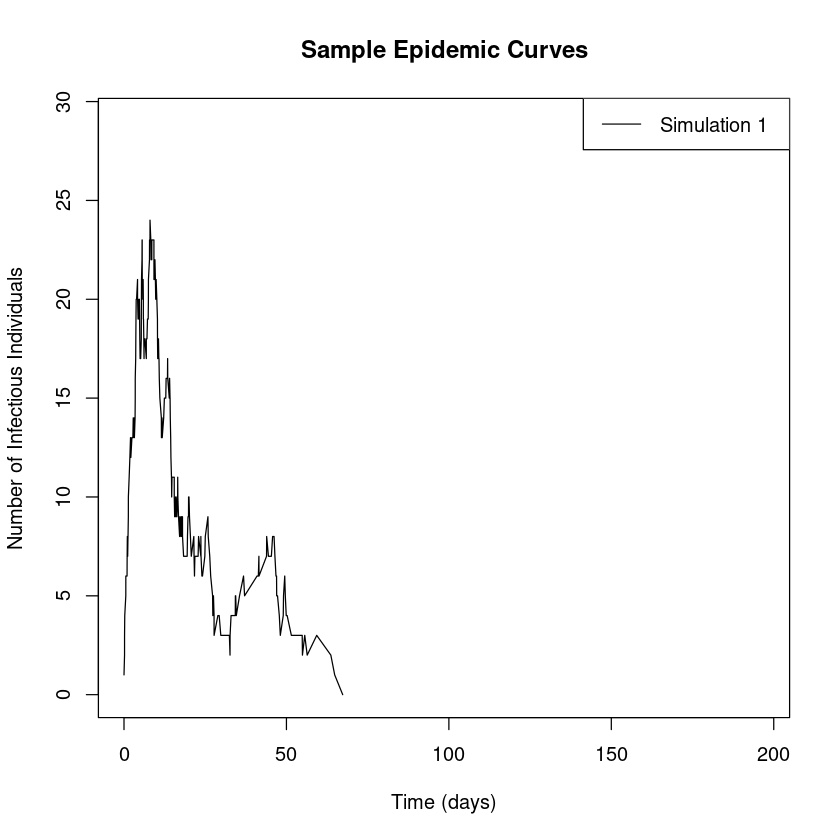

In [34]:
# Plot a few sample simulations
# sample_indices <- sample(1:num_simulations, 5)
sample_indices <- sample(1)


plot(NULL, xlim = c(0, max(times)), ylim = c(0, max(sapply(all_simulations, function(sim) max(sim$I)))), 
     xlab = "Time (days)", ylab = "Number of Infectious Individuals", main = "Sample Epidemic Curves")

for(i in sample_indices) {
  lines(all_simulations[[i]]$time, all_simulations[[i]]$I, col = i, type = "l")
}

legend("topright", legend = paste("Simulation", sample_indices), col = sample_indices, lty = 1)


## Markove Chain Model Version 3 for the Time of Intervention Delay

## Initial Conditions

In [40]:
# Parameters and initial conditions
params <- c(
  beta_0 = 0.23,
  beta_1 = 0.09,
  k = 1/5.3,
  gamma = 1/5.61,
  tau = 56,
  q = 25,
  N = 300
)

initial_conditions <- c(S = 250, E = 40, I = 10, R = 0, C = 0)
times <- seq(1, 197, by = 1)


In [41]:
# Stochastic SEIR model using Gillespie Algorithm
seir_gillespie <- function(params, initial_conditions, times) {
  t <- 0
  results <- data.frame(time = t, S = initial_conditions["S"], E = initial_conditions["E"], I = initial_conditions["I"], R = initial_conditions["R"], C = initial_conditions["C"])
  
  while(t < max(times)) {
    S <- results$S[nrow(results)]
    E <- results$E[nrow(results)]
    I <- results$I[nrow(results)]
    R <- results$R[nrow(results)]
    C <- results$C[nrow(results)]
    
    N <- params["N"]
    gamma <- params["gamma"]
    k <- params["k"]
    beta <- beta_tt(t, params)
    
    # Rates of transitions
    rate_infection <- beta * S * I / N
    rate_exposed_to_infectious <- k * E
    rate_infectious_to_removed <- gamma * I
    
    rates <- c(rate_infection, rate_exposed_to_infectious, rate_infectious_to_removed)
    total_rate <- sum(rates)
    
    if(total_rate == 0) break
    
    # Time to next event
    dt <- rexp(1, total_rate)
    t <- t + dt
    
    # Determine which event occurs
    event <- sample(1:3, 1, prob = rates)
    
    if(event == 1 && S > 0) {
      S <- S - 1
      E <- E + 1
    } else if(event == 2 && E > 0) {
      E <- E - 1
      I <- I + 1
      C <- C + 1
    } else if(event == 3 && I > 0) {
      I <- I - 1
      R <- R + 1
    }
    
    results <- rbind(results, data.frame(time = t, S = S, E = E, I = I, R = R, C = C))
  }
  
  return(results)
}


In [42]:

# Number of simulations for each tau
num_simulations <- 250

# Define range of intervention times (tau)
tau_values <- seq(0, 197, by = 1)

# Collect results
final_sizes <- data.frame(tau = tau_values, mean_final_size = NA, sd_final_size = NA)

for (tau in tau_values) {
  params["tau"] <- tau
  epidemic_sizes <- numeric(num_simulations)
  
  for (i in 1:num_simulations) {
    sim_result <- seir_gillespie(params, initial_conditions, times)
    epidemic_sizes[i] <- max(sim_result$C)
  }
  
  final_sizes[final_sizes$tau == tau, "mean_final_size"] <- mean(epidemic_sizes)
  final_sizes[final_sizes$tau == tau, "sd_final_size"] <- sd(epidemic_sizes)
}


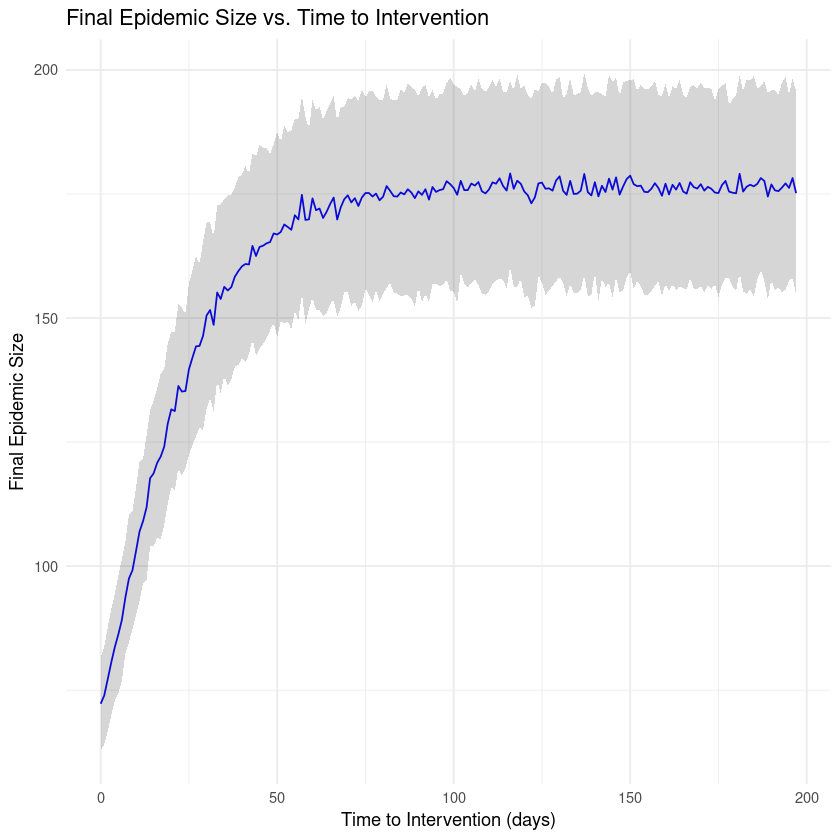

In [43]:
# Load necessary library
library(ggplot2)

# Plot final epidemic size vs. time to intervention
ggplot(final_sizes, aes(x = tau, y = mean_final_size)) +
  geom_line(color = "blue") +
  geom_ribbon(aes(ymin = mean_final_size - sd_final_size, ymax = mean_final_size + sd_final_size), alpha = 0.2) +
  labs(title = "Final Epidemic Size vs. Time to Intervention",
       x = "Time to Intervention (days)",
       y = "Final Epidemic Size") +
  theme_minimal()
